In [11]:
# !pip install --upgrade jupyter
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
!pip install jupyterlab

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.11
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/taylorm/.conda/envs/espr

  added / updated specs:
    - nodejs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         128 KB  anaconda
    certifi-2020.6.20          |           py37_0         159 KB  anaconda
    nodejs-10.13.0             |       he6710b0_0        15.4 MB  anaconda
    openssl-1.1.1h             |       h7b6447c_0         3.8 MB  anaconda
    ------------------------------------------------------------
                                           Total:        19.5 MB

The following NEW packages will be INSTALLED:

  nodejs             anaconda/linux-64::nodejs-10.13.

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
import os
from datetime import datetime, timedelta
import xarray as xr
import scipy.signal as ss
from scipy.spatial import distance as dist
from scipy.ndimage import gaussian_filter, uniform_filter
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as ft
import numpy as np
import itertools
import pandas as pd
from collections import OrderedDict
import cProfile, pstats
from tqdm import tqdm_notebook

In [4]:
era5_slp = xr.open_dataset('~/espr/era5/mslp.nc',chunks={'time':100,'latitude':100,'longitude':100})

In [5]:
class CentroidFinder:
    def __init__(self, ds, threshold=5, use_first_var=True, **kwargs):
        self.ds = ds
        self.threshold = threshold
        self.i = 0
        if use_first_var:
            self.da = self.ds[[n for n in ds.data_vars.keys()][0]]
        else:
            try:
                data_var = kwargs['data_var']
                self.da = self.ds[data_var]
            except:
                'variable data_var must be set if not using first available variable in xarray dataset'
        if 'resolution' in kwargs.keys():
            self.res = kwargs['resolution']
        else:
            self.res = 1
        self.dims = len(self.da.shape)
        
    ##to be put into utils file
    def detect_local_minima(self, arr):
        # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
        """
        Takes an array and detects the troughs using the local maximum filter.
        Returns a boolean mask of the troughs (i.e. 1 when
        the pixel's value is the neighborhood maximum, 0 otherwise)
        """
        # define an connected neighborhood
        # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
        neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
        # apply the local minimum filter; all locations of minimum value 
        # in their neighborhood are set to 1
        # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
        local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
        # local_min is a mask that contains the peaks we are 
        # looking for, but also the background.
        # In order to isolate the peaks we must remove the background from the mask.
        # 
        # we create the mask of the background
        background = (arr==0)
        # 
        # a little technicality: we must erode the background in order to 
        # successfully subtract it from local_min, otherwise a line will 
        # appear along the background border (artifact of the local minimum filter)
        # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
        eroded_background = morphology.binary_erosion(
            background, structure=neighborhood, border_value=1)
        # 
        # we obtain the final mask, containing only peaks, 
        # by removing the background from the local_min mask
        detected_minima = local_min ^ eroded_background
        return np.where(detected_minima)       

    def minima_filter(self, **kwargs):
        if self.dims == 2:
            if 'edge_radius' in kwargs.keys():
                H1 = uniform_filter(self.da[self.edge_radius:-self.edge_radius,self.edge_radius:-self.edge_radius],size=10,mode='nearest')
            else:
                H1 = uniform_filter(self.da,size=10,mode='nearest')
            gradx,grady = np.gradient(H1)
            gradxx = np.gradient(gradx.copy())[0]
            gradyy = np.gradient(grady.copy())[1]
            gradxy = np.gradient(gradx.copy())[1]
        elif self.dims == 3:
            if 'edge_radius' in kwargs.keys():
                edge_radius = kwargs['edge_radius']
                if self.tqdm:
                    H1 = np.array([uniform_filter(n[self.edge_radius:-self.edge_radius,self.edge_radius:-self.edge_radius],size=10,mode='nearest') for n in tqdm_notebook(self.da)])
                else:
                    H1 = np.array([uniform_filter(n[self.edge_radius:-self.edge_radius,self.edge_radius:-self.edge_radius],size=10,mode='nearest') for n in self.da])
            else:
                if self.tqdm:
                    H1 = np.array([uniform_filter(n,size=10,mode='nearest') for n in tqdm_notebook(self.da)])
                else:
                    H1 = np.array([uniform_filter(n,size=10,mode='nearest') for n in self.da])
            gradx,grady = np.gradient(H1,axis=(1,2))
            gradxx = np.gradient(gradx.copy(),axis=(1,2))[0]
            gradyy = np.gradient(grady.copy(),axis=(1,2))[1]
            gradxy = np.gradient(gradx.copy(),axis=(1,2))[1]
        else:
            assert self.dims <= 3, 'filter requires dims <= 3'
        h = gradxx*gradyy - gradxy**2
        h[h < .1] = np.nan
        h[gradxx < 0] = np.nan   
        h[gradyy < 0] = np.nan   
        h[H1>101800] = np.nan
        h[h<np.nanquantile(h,.90)] = np.nan
        return h
    
    def euclidian_mask(self, p1, p2):
        lat1 = float(p1[0])
        lat2 = float(p2[0])
        lon1 = float(p1[1] % 360)
        lon2 = float(p2[1] % 360)
        
        if abs(lat1-lat2) > self.threshold or abs(lon1-lon2) > self.threshold:
            return False
        else:
            dist = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
            return dist < self.threshold*4

    def euclidian_mask_non_xr(self, p1, p2):
        lat1 = float(p1[0])
        lat2 = float(p2[0])
        lon1 = float(p1[1])
        lon2 = float(p2[1])
        if abs(lat1-lat2) > self.threshold/self.res or abs(lon1-lon2) > self.threshold/self.res:
            return False
        else:
            dist = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
            return dist < self.threshold/self.res        
        
    def filter_points(self, field, coord1, coord2):
        
        mins = np.maximum(field.sel(latitude=coord1[0],longitude=coord1[1]).values,
                         field.sel(latitude=coord2[0],longitude=coord2[1]).values)
        outs = [coord1,coord2][np.where([field.sel(latitude=coord1[0],longitude=coord1[1]).values,
                         field.sel(latitude=coord2[0],longitude=coord2[1]).values]==mins)[0][0]]
        return outs
    
    def filter_points_non_xr(self, coord1, coord2):
        field_inm = self.da[self.i,self.edge_radius:-self.edge_radius,self.edge_radius:-self.edge_radius].values
        try:
            mins = np.maximum(field_inm[coord1[0],coord1[1]],field_inm[coord2[0],coord2[1]])
        except:
            import pdb; pdb.set_trace()
        outs = [coord1,coord2][np.where([field_inm[coord1[0],coord1[1]],field_inm[coord2[0],coord2[1]]]==mins)[0][0]]
        return outs
    
    def _create_coord_tuples(self, h, lat_map, lon_map):
        coords = self.detect_local_minima(-h)
        coords_ll = (lat_map[coords[0]],lon_map[coords[1]])
        coords_list = [(coords[0][n],coords[1][n]) for n in range(len(coords[0]))]
        
        out_mask = [self.filter_points_non_xr(*n) for n in\
                            itertools.combinations(coords_list,2) if self.euclidian_mask_non_xr(*n)]
        out_mask = [(lat_map[n[0]],lon_map[n[1]]) for n in out_mask]
        coords_list = [(lat_map[n[0]],lon_map[n[1]]) for n in coords_list]
        self.i += 1
        return [x for x in coords_list if x not in out_mask]
    
    def _test_plot(self, lats, lons, iteration=0):
        fig,ax = plt.subplots(figsize=(20,5),subplot_kw=dict(projection=ccrs.PlateCarree()))
        if self.dims == 3:
            quad1 = self.da[iteration].plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=50,cbar_kwargs={'spacing': 'proportional',
                                                                                          'fraction':0.02,'pad':0.01})
            contour = (self.da[iteration]/100).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=50,colors='k',linewidths=0.5)
        elif self.dims == 2:
            quad1 = self.da.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=50,cbar_kwargs={'spacing': 'proportional',
                                                                                          'fraction':0.02,'pad':0.01})
            contour = (self.da/100).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=50,colors='k',linewidths=0.5)
        plt.clabel(contour,fmt='%1.0f')
        scatter = ax.scatter(lons,lats,transform=ccrs.PlateCarree(),c='r')
        ax.coastlines()
        plt.show()    
        
    def identify_centroids(self, plot_map=False, **kwargs):
        if 'tqdm' in kwargs.keys():
            assert isinstance(kwargs['tqdm'],bool), 'tqdm must be bool'
            self.tqdm = kwargs['tqdm']
        else:
            self.tqdm = False
        if 'remove_edges' in kwargs.keys():
            if kwargs['remove_edges']:
                try:
                    self.edge_radius = int(np.round(kwargs['edge_radius']/self.res))
                except:
                    self.edge_radius = int(np.round(5/self.res))           
            h = self.minima_filter(edge_radius=True)
            lat_map = self.da.latitude.values[self.edge_radius:-self.edge_radius]
            lon_map = self.da.longitude.values[self.edge_radius:-self.edge_radius]
        else:           
            h = self.minima_filter()
            lat_map = self.da.latitude.values
            lon_map = self.da.longitude.values
        if self.dims == 2:
            coords_list = self._create_coord_tuples(h, lat_map, lon_map)
            lats = [n[0] for n in coords_list]
            lons = [n[1] for n in coords_list]
            if plot_map:
                self._test_plot(lats, lons)
        elif self.dims == 3:
            if self.tqdm:
                coords_list = [self._create_coord_tuples(n, lat_map, lon_map) for n in tqdm_notebook(h)]
            else:
                coords_list = [self._create_coord_tuples(n, lat_map, lon_map) for n in h]
            i=0
            for valid in coords_list:
                lats = [n[0] for n in valid]
                lons = [n[1] for n in valid]
                if plot_map:
                    self._test_plot(lats, lons,iteration=i)
                i+=1
        return coords_list
    
    def subset_time(self, period, iloc=False):
        try:
            if len(period) == 1:
                if iloc:
                    self.da = self.da[period]
                else:
                    self.da = self.da.loc[period]
            else:
                if iloc:
                    assert isinstance(period[0], int), f'period must be int if using iloc'
                    assert len(period) == 2, f'period must have only two values'
                    self.da = self.da[period[0]:period[-1]]
                else:
                    assert len(period) == 2, 'period must have two values, beginning and end date'
                    self.da = self.da.loc[period[0]:period[-1]]
        except TypeError:
                if iloc:
                    self.da = self.da[period]
                else:
                    self.da = self.da.loc[period]
            
        self.dims = len(self.da.shape)
        
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def cent(num_times):
    centroid = CentroidFinder(era5_slp,resolution=0.25)
    centroid.subset_time(num_times,iloc=True)
    coords_list = centroid.identify_centroids()
    return coords_list

def conv_to_filter(da):
    conv = ss.convolve2d(da,small_uniform,boundary='symm',mode='same')
    test_filter = conv.copy()
    test_filter[test_filter>np.quantile(test_filter,0.01)] = np.nan
    outs = detect_local_minima(test_filter)
    return test_filter, outs

def conv_kernel_array(filter_size_in_deg, model_res):
    array_size = int(filter_size_in_deg/model_res)
    kernel = np.ones((array_size,array_size))/array_size**2
    return kernel

In [ ]:
time = pd.date_range('2007-01-01','2014-02-28', freq='D')
time = time[time.month.isin([12,1,2])]
centroid = CentroidFinder(era5_slp.sel(time=time, latitude=slice(60,30), longitude=slice(-85,-30)), resolution=0.25)
centroid.subset_time((time[0].strftime('%Y-%m-%d'),time[-1].strftime('%Y-%m-%d')))
coords = centroid.identify_centroids(plot_map=False, remove_edges=True, edge_radius=7.5,tqdm=True)

In [30]:
rel_list = []
for i,n in enumerate(coords):
    print(n)
    for coord in n:
        rel_list.append(era5_slp.msl.sel(time=time,latitude=slice(60,30),
                                         longitude=slice(-85,-30)).isel(time=i).sel(latitude=slice(coord[0]+8,coord[0]-8),
                                                                                    longitude=slice(coord[1]-8,coord[1]+8)))
rel_list_values = np.array([n.values for n in rel_list])

[(42.25, -49.0)]
[(52.0, -70.5), (47.25, -42.75)]
[(48.25, -55.25)]
[(52.0, -45.75)]
[]
[]
[(47.5, -69.0)]
[(50.0, -49.25), (42.75, -77.0)]
[(49.0, -72.0), (46.5, -63.5)]
[]
[(42.75, -55.0)]
[]
[]
[(47.0, -55.0)]


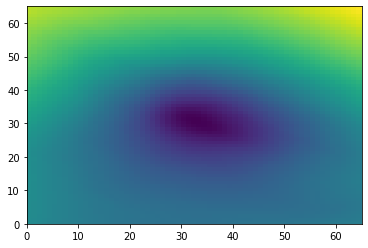

In [42]:
plt.pcolormesh(np.mean(rel_list_values,axis=0))

In [ ]:

time = pd.date_range('2007-01-01', freq='D', periods=56)
centroid = CentroidFinder(era5_slp.sel(latitude=slice(60,30),longitude=slice(-85,-30),time=time),resolution=0.25)
centroid.subset_time((time[0].strftime('%Y-%m-%d'),time[-1].strftime('%Y-%m-%d')))
# coords_list = centroid.identify_centroids()
profiler = cProfile.Profile()
profiler.enable()
centroid.identify_centroids(plot_map=False,remove_edges=True,edge_radius=7.5)
profiler.disable()


In [56]:
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats('cumtime').print_stats()

         403163 function calls (394098 primitive calls) in 8.858 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    8.859    4.429 interactiveshell.py:3288(run_code)
        2    0.000    0.000    8.859    4.429 {built-in method builtins.exec}
        1    0.000    0.000    8.859    8.859 <ipython-input-55-8c835abd526a>:9(<module>)
        1    0.000    0.000    8.858    8.858 <ipython-input-54-e686b886a1c2>:151(identify_centroids)
1318/1204    0.007    0.000    8.424    0.007 {built-in method numpy.array}
1139/1025    0.001    0.000    8.424    0.008 _asarray.py:14(asarray)
      115    0.000    0.000    8.378    0.073 dataarray.py:566(values)
      115    0.000    0.000    8.377    0.073 variable.py:507(values)
      115    0.001    0.000    8.377    0.073 variable.py:255(_as_array_or_item)
      113    0.001    0.000    8.375    0.074 core.py:1308(__array__)
      113    0.176    0.002    8.

     1091    0.002    0.000    0.003    0.000 dataarray.py:585(dims)
      226    0.003    0.000    0.003    0.000 {built-in method posix.urandom}
     2036    0.002    0.000    0.003    0.000 {built-in method builtins.next}
      336    0.001    0.000    0.002    0.000 <__array_function__ internals>:2(iscomplexobj)
      168    0.002    0.000    0.002    0.000 {built-in method numpy.zeros}
      452    0.002    0.000    0.002    0.000 {method 'put' of '_queue.SimpleQueue' objects}
        4    0.000    0.000    0.002    0.001 fromnumeric.py:52(_wrapfunc)
     5920    0.002    0.000    0.002    0.000 variable.py:545(dims)
      226    0.001    0.000    0.002    0.000 core.py:1050(__dask_keys__)
      226    0.002    0.000    0.002    0.000 uuid.py:121(__init__)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:2(nonzero)
      507    0.001    0.000    0.002    0.000 core.py:2471(<genexpr>)
      284    0.001    0.000    0.002    0.000 contextlib.py:237(helper

      226    0.000    0.000    0.000    0.000 {method 'join' of 'str' objects}
      113    0.000    0.000    0.000    0.000 context.py:59(__get__)
      226    0.000    0.000    0.000    0.000 base.py:236(<genexpr>)
      169    0.000    0.000    0.000    0.000 slicing.py:800(<listcomp>)
      344    0.000    0.000    0.000    0.000 coordinates.py:271(__init__)
      452    0.000    0.000    0.000    0.000 {method '__exit__' of '_thread.lock' objects}
      452    0.000    0.000    0.000    0.000 order.py:260(__init__)
      224    0.000    0.000    0.000    0.000 _ni_support.py:35(_extend_mode_to_code)
      452    0.000    0.000    0.000    0.000 {method 'append' of 'collections.deque' objects}
      169    0.000    0.000    0.000    0.000 indexing.py:1328(__init__)
        5    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(moveaxis)
      113    0.000    0.000    0.000    0.000 enum.py:633(value)
      226    0.000    0.000    0.000    0.000 {method 'count' of '